# Preprocessing steps analysis for Stanford datasets

### Import modules and define methods

In [2]:
%reload_ext autoreload
%autoreload 2

import os
from preprocess import *
from argparse import Namespace
import skimage.exposure as exp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import subtle.utils.io as suio

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

from tqdm import tqdm_notebook as tqdm
import subtle.subtle_preprocess as supre

metadata={
    'lambda': []
}

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)

def show_gad_comparison(img_pre, img_low, img_post, vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title='Pre contrast', vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title='10% dosage', vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title='Full dosage', vmin=vmin, vmax=vmax)

    plt.show()

def show_comparison(img1, img2, titles=['', ''], vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 2, 1)
    show_img(img1, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 2, 2)
    show_img(img2, title=titles[1], vmin=vmin, vmax=vmax)
    
    plt.show()

def iminfo(img):
    print(img.shape, img.dtype, img.min(), img.max(), img.mean())

def diff_img(img1, img2, abs_diff=True):
    diff = np.subtract(img1.astype(np.float32), img2.astype(np.float32))
    if not abs_diff:
        return diff
    
    # return np.abs(diff).astype(np.float32)
    return diff

def show_hist(img, nbins=512, title=''):
    rav = img.ravel()
    rav = rav[rav != 0]
    plt.hist(rav, bins=nbins, log=True)
    plt.title(title)
    plt.xlabel('Pixel values')
    plt.ylabel('log10 Count')
    plt.show()

def show_final_comparison(img_pre, img_low, img_post):
    fig = plt.figure(figsize=(15, 12))
    fig.tight_layout()
    
    imstack = np.hstack((img_pre, img_low, img_post))
    abs_diff = True
    
    scale_factor = 5
    
    diff0 = diff_img(img_pre, img_pre, abs_diff)
    diff1 = diff_img(img_low, img_pre, abs_diff)
    diff2 = diff_img(img_post, img_pre, abs_diff)
    
    diff = np.hstack((diff0, diff1 * scale_factor, diff2 * scale_factor))
    
    final_disp = np.vstack((imstack, diff))
    
    show_img(final_disp, vmin=imstack.min(), vmax=imstack.max())

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')
/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

### Initialize dummy argparse Namespace

In [28]:
args = Namespace(
    path_base='/home/srivathsa/projects/studies/gad/stanford/data/Patient_0183', verbose=True,
    output='/home/srivathsa/projects/studies/gad/stanford/preprocess/data/dummy.h5',
    discard_start_percent=0, discard_end_percent=0, normalize=True,
    normalize_fun='mean', transform_type='affine', scale_matching=True,
    path_zero=None, path_low=None, path_full=None, mask_threshold=0.1,
    override=False, skip_mask=False, scale_dicom_tags=False, skip_hist_norm=True,
    skip_registration=False, nslices=20, joint_normalize=False, global_scale_ref_im0=False, noise_mask_area=False,
    fsl_mask=True, fsl_mask_all_ims=True, use_fsl_reg=False, fsl_threshold=0.5, blur_for_cs_streaks=False
)

### Fetch original images

In [29]:
ims, hdr, metadata = get_images(args, metadata)
ims = ims.transpose(2, 1, 0, 3)
ims = np.rot90(ims, axes=(2, 3), k=2)
orig_ims = np.copy(ims)
pidx = 317#ims.shape[0] // 2

path_zero = /home/srivathsa/projects/studies/gad/stanford/data/Patient_0183/7_AX_BRAVO
path_low = /home/srivathsa/projects/studies/gad/stanford/data/Patient_0183/10_AX_BRAVO_+C_Pre_Load_10
path_full = /home/srivathsa/projects/studies/gad/stanford/data/Patient_0183/13_AX_BRAVO_+C
image sizes:  (320, 512, 512) (320, 512, 512) (320, 512, 512)


(512, 320, 512) float32 0.0 8407.0 468.77655
(512, 320, 512) float32 0.0 10169.0 488.58813
(512, 320, 512) float32 0.0 17708.0 808.6909


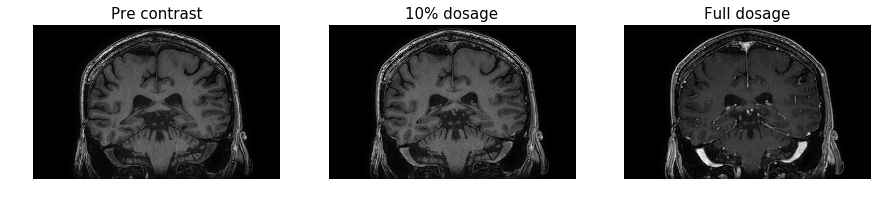

In [30]:
iminfo(ims[:, 0])
iminfo(ims[:, 1])
iminfo(ims[:, 2])

show_gad_comparison(ims[pidx, 0], ims[pidx, 1], ims[pidx, 2])

### Mask images

In [31]:
ims, mask, metadata = mask_images(args, ims, metadata)

masking


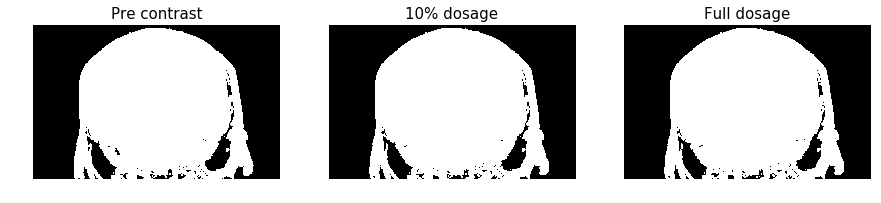

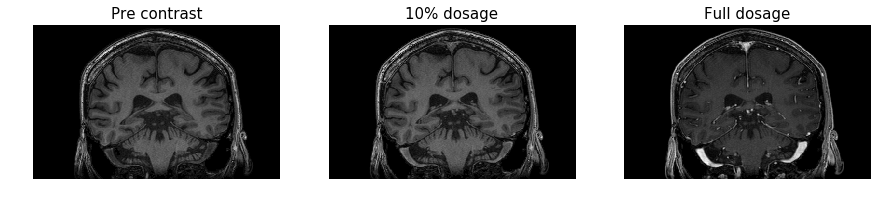

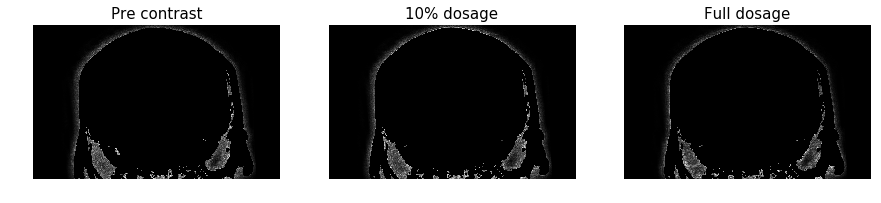

In [32]:
show_gad_comparison(mask[pidx, 0], mask[pidx, 1], mask[pidx, 2])
show_gad_comparison(ims[pidx, 0], ims[pidx, 1], ims[pidx, 2])

pre_diff = diff_img(orig_ims[pidx, 0], ims[pidx, 0])
low_diff = diff_img(orig_ims[pidx, 1], ims[pidx, 1])
post_diff = diff_img(orig_ims[pidx, 2], ims[pidx, 2])

show_gad_comparison(pre_diff, low_diff, post_diff)

In [67]:
fsl_mask = fsl_brain_mask(args, ims)

Extracting brain regions using deepbrain...
BET Zero
BET Low
BET Full


In [68]:
ims_mask = apply_fsl_mask(args, ims, fsl_mask)

Applying computed FSL masks on images


In [12]:
ref_fixed = sup.dcm_to_sitk('/home/srivathsa/projects/studies/gad/stanford/data/Patient_0345/7_AX_BRAVO_PRE/')
ref_moving = sup.dcm_to_sitk('/home/srivathsa/projects/studies/gad/stanford/data/Patient_0345/10_AX_BRAVO_+C_Pre_Load_10/')

In [69]:
import SimpleITK as sitk

pm = sitk.GetDefaultParameterMap('affine')
reg_ims = np.copy(ims)

reg_ims[:, 1], param_map = sup.register_im(ims[:, 0], ims[:, 1], param_map=pm, verbose=1, 
                               im_fixed_spacing=metadata['pixel_spacing_zero'], 
                               im_moving_spacing=metadata['pixel_spacing_low'])
reg_ims[:, 2], param_map = sup.register_im(ims[:, 0], ims[:, 2], param_map=pm, verbose=1, 
                     
                                           im_fixed_spacing=metadata['pixel_spacing_zero'], 
                               im_moving_spacing=metadata['pixel_spacing_full'])

print(param_map[0]['TransformParameters'])

image registration
registration done, 8.51 s
image registration
registration done, 8.5 s
('1.0008', '0.00901009', '0.00667061', '-0.0101215', '1.00119', '0.0266093', '-0.00662457', '-0.0308493', '0.997902', '-0.351533', '0.271336', '0.131922')


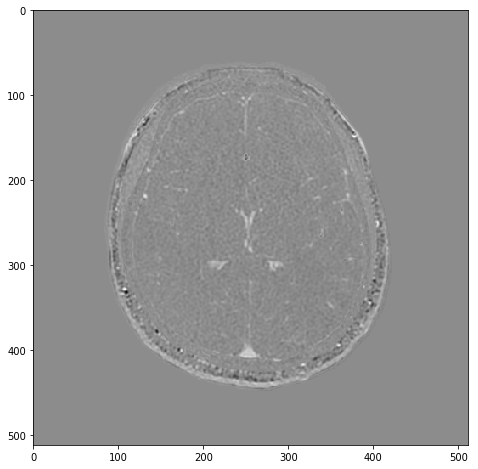

In [61]:
plt.imshow(reg_ims[pidx, 1] - reg_ims[pidx, 0])

In [14]:
param_map[0]['TransformParameters'] = ['0.00149806', '-0.00961922', '0.00327058', '0.23644', '-0.665825', '4.7988']

mod_ims = np.copy(ims)
mod_ims[:, 1] = sup.apply_reg_transform(ims[:, 1], metadata['pixel_spacing_low'], param_map)

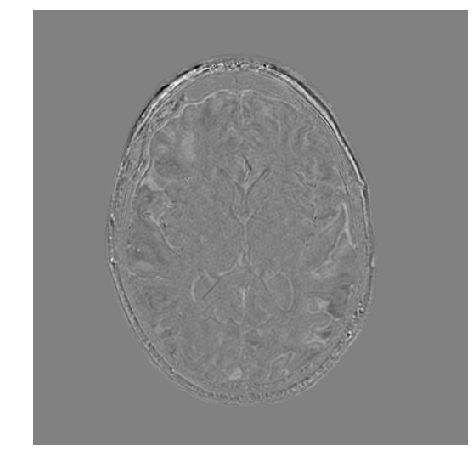

In [15]:
show_img(mod_ims[pidx, 1] - ims[pidx, 0])

### Image registration

In [ ]:
orig_ims = np.copy(ims)
ims, metadata = register(args, ims, metadata)

In [ ]:
iminfo(ims[172, 0])
iminfo(ims[172, 1])
iminfo(ims[172, 2])

show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])

pre_diff = diff_img(orig_ims[172, 0], ims[172, 0])
low_diff = diff_img(orig_ims[172, 1], ims[172, 1])
post_diff = diff_img(orig_ims[172, 2], ims[172, 2])

# show_gad_comparison(pre_diff, low_diff, post_diff)

show_comparison(ims[172, 1] - ims[172, 0], ims[172, 2] - ims[172, 0])

### FSL Mask

In [ ]:
fsl_mask = fsl_brain_mask(args)
ims = apply_fsl_mask(args, ims, fsl_mask)

### Histogram normalization

In [ ]:
orig_ims = np.copy(ims)
ims, metadata = hist_norm(args, ims, metadata)

In [ ]:
vmin = ims[:, 0].min()
vmax = ims[:, 0].max()

diff = np.abs(ims[:, 0] - ims[:, 2])
vmin, vmax = (diff.min(), diff.max())

th = diff.max() * 0.25
mask = diff >= th

full_masked = (ims[:, 2] * mask)

recon = ims[:, 0] + full_masked

x1=280
x2=340
y1=360
y2=420

im1 = ims[pidx, 0]
im2 = ims[pidx, 1]
im3 = ims[pidx, 2]

stack = np.hstack([im1, im3])

fig, ax = plt.subplots(1)
ax.imshow(stack, vmin=vmin, vmax=vmax)
rect = Rectangle((180, 375), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

p1 = im1[160:180, 355:375]
p2 = im3[160:180, 355:375]

print(p1.mean(), p2.mean())

show_comparison(p1, p2)
#show_comparison(im1, im3, vmin=vmin, vmax=vmax)

In [ ]:
iminfo(ims[172, 0])
iminfo(ims[172, 1])
iminfo(ims[172, 2])

show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])
show_comparison(diff_img(ims[172, 0], ims[172, 1]), diff_img(ims[172, 0], ims[172, 2]))

### Zoom

In [ ]:
args.zoom = 512
args.zoom_order = 1

ims_zoom, metadata = zoom_process(args, ims, metadata)

In [ ]:
iminfo(ims_zoom)
show_gad_comparison(ims_zoom[172, 0], ims_zoom[172, 1], ims_zoom[172, 2])

### Match scales and global normalization

In [ ]:
orig_ims = np.copy(ims)

ims, ims_mod, metadata = prescale_process(args, ims, mask, metadata)
ims, ims_mod, metadata = match_scales(args, ims, ims_mod, metadata)
ims, metadata = global_norm(args, ims, ims_mod, metadata)

In [ ]:
iminfo(ims[:, 0])
iminfo(ims[:, 1])
iminfo(ims[:, 2])

show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])

In [ ]:
show_hist(ims[:, 0], nbins=255, title='Pre contrast')
show_hist(ims[:, 1], nbins=255, title='10% dosage')
show_hist(ims[:, 2], nbins=255, title='Full dosage')

In [ ]:
show_final_comparison(ims[172, 0], ims[172, 1], ims[172, 2])

In [ ]:
pp_data = suio.load_file('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0089.npy')
pp_mask = pp_data[1]

In [ ]:
plt.imshow(pp_mask[160, 1] - pp_mask[160, 0])